In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time
import SimpleITK as sitk
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [4]:
annotations_file = r'C:\Users\user\Downloads\pfa\CSVFILES\annotations.csv'
annotations_table = pd.read_csv(annotations_file)

candidates_file = r'C:\Users\user\Downloads\pfa\CSVFILES\candidates.csv'
candidates_table = pd.read_csv(candidates_file)

In [5]:
def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume=sitk.ReadImage(path,sitk.sitkFloat32)
    # Resize width, height and depth to (32,32)
    volume=sitk.BinShrink(volume, [16,16,1])
    return volume




In [6]:
def display_ITK_image(ITK_img,z):
    img=sitk.GetArrayFromImage(ITK_img)
    plt.imshow(img[z])
    plt.axis("on")
    plt.show()

In [7]:
def get_voxel_Z(self,z):
        """
        Converts Cartesian to voxel coordinates
        """
        origin = self.GetOrigin()
        resolution = self.GetSpacing()
        zz=(z-origin[2])/resolution[2]
        return zz

In [8]:
def getImage(img_id):
    normal=[]
    nodule=[]
    z_list=[]
    img_ITK=sitk.BinShrink(sitk.ReadImage('C:/Users/user/Downloads/pfa/dataset/'+ img_id + '.mhd', sitk.sitkFloat32),[16,16,1])
    img_np= sitk.GetArrayFromImage(img_ITK)
    bboxs = annotations_table[annotations_table['seriesuid']==img_id]
    for index, row in bboxs.iterrows():
        z=row['coordZ']
        zz=int(get_voxel_Z(img_ITK,z))
        z_list=z_list+[zz]
        nodule=nodule+[img_np[zz]]
    for i in range(img_np.shape[0]):
        if i not in z_list:
            normal=normal+[img_np[i]]
    
    return(normal,nodule)

    
        


In [9]:

normal_scans=[]
abnormal_scans=[]
i=0
for img_id in annotations_table['seriesuid']:
    if i<21 :
        (normal,nodule)=getImage(img_id)
        normal_scans=normal_scans+normal
        abnormal_scans=abnormal_scans+nodule
        i=i+1
    else : break
    

print("CT scans with normal lung : " + str(len(normal_scans)))
print("CT scans with nodules : " + str(len(abnormal_scans)))

CT scans with normal lung : 4837
CT scans with nodules : 57


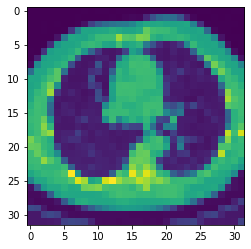

In [10]:
plt.imshow(abnormal_scans[1])
plt.axis("on")
plt.show()

In [11]:
abnormal_scans=np.array([abnormal_scans[i] for i in range(len(abnormal_scans))])
normal_scans=np.array([normal_scans[i] for i in range(len(normal_scans))])


abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:40], normal_scans[:3386]), axis=0)
y_train = np.concatenate((abnormal_labels[:40], normal_labels[:3386]), axis=0)
x_val = np.concatenate((abnormal_scans[40:], normal_scans[3386:]), axis=0)
y_val = np.concatenate((abnormal_labels[40:], normal_labels[3386:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 3426 and 1468.


In [12]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(2)
)

In [13]:
def get_model(width=32, height=32, depth=32):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256   

In [14]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2, 
    callbacks=[checkpoint_cb, early_stopping_cb],
    )

Epoch 1/100


ValueError: in user code:

    C:\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer 3dcnn: expected shape=(None, 128, 128, 64, 1), found shape=(None, 32, 32)
